In [3]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

CRITICAL_TEMP = 2.26918

In [6]:
def magnetisation(lattice):
    return np.sum(lattice) / lattice.size


# return i in the lattice with periodic boundary conditions
def boundary_conditions(n, i):
    i = n - 1 if i < 0 else i
    i = 0 if i > n - 1 else i

    return i


def delta_energy(lattice, i, j):
    flipped_spin = -1 * lattice[i][j]

    idx_above = boundary_conditions(n, j + 1)
    idx_below = boundary_conditions(n, j - 1)
    idx_left = boundary_conditions(n, i - 1)
    idx_right = boundary_conditions(n, i + 1)

    neighbour_sum = lattice[i][idx_above] + lattice[i][idx_below] + lattice[idx_left][j] + lattice[idx_right][j]

    init_energy = - lattice[i][j] * neighbour_sum
    new_energy = - flipped_spin * neighbour_sum

    return new_energy - init_energy


def metropolis_update(lattice, temperature):
    for i in range(lattice.shape[0]):
        for j in range(lattice.shape[1]):

            if math.exp(-delta_energy(lattice, i, j) / temperature) > random.random():
                # flip the spin
                lattice[i][j] *= -1


In [13]:
steps = 100
n = 30
temperature = 1.2

lattice = np.ones((n, n))
mags = []

for t in range(steps):
    metropolis_update(lattice, temperature)
    mags.append(magnetisation(lattice))



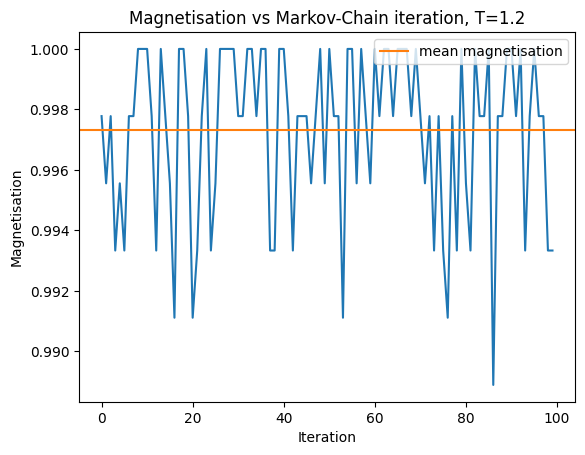

In [14]:
plt.plot(mags)
plt.axhline(np.mean(mags), color='tab:orange', label='mean magnetisation')
plt.xlabel('Iteration')
plt.ylabel('Magnetisation')
plt.title('Magnetisation vs Markov-Chain iteration, T={}'.format(temperature))
plt.legend(loc='upper right')
plt.show()


In [15]:
steps = 1000
n = 10

temperatures = np.arange(0.1, 4, 0.2)
mean_magnetisations = []

for temp in temperatures:
    lattice = np.ones((n, n))
    mags = []

    for t in range(steps):
        metropolis_update(lattice, temp)
        mags.append(magnetisation(lattice))

    mean_mag = np.abs(np.mean(mags))
    mean_magnetisations.append(mean_mag)


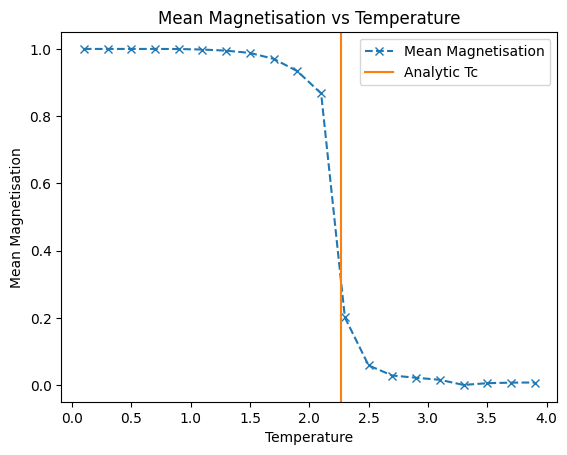

In [25]:
plt.plot(temperatures, mean_magnetisations, label='Mean Magnetisation', linestyle = '--', marker='x')
plt.axvline(CRITICAL_TEMP, color='tab:orange', label='Analytic Tc')
plt.xlabel('Temperature')
plt.ylabel('Mean Magnetisation')
plt.title('Mean Magnetisation vs Temperature')
plt.legend(loc='upper right')
plt.show()


Now lets use the optimised algorithm with checkerboard lattice where we do half updates vectorised

In [27]:
class Ising:
    def __init__(self, n, temperature):
        # n must be even
        self.n = n if n % 2 == 0 else n - 1
        self.temperature = temperature

        self.lattice1 = np.ones((self.n, self.n // 2))
        self.lattice2 = np.ones((self.n, self.n // 2))

    def magnetisation(self):
        return np.sum(self.lattice1 + self.lattice2) / self.n ** 2

    def delta_energy(self):
        neighbour_sum = np.copy(self.lattice2)
        neighbour_sum += np.roll(self.lattice2, (-1, 0), axis=(1, 0))
        neighbour_sum += np.roll(self.lattice2, (0, 1), axis=(1, 0))
        neighbour_sum += np.roll(self.lattice2, (0, -1), axis=(1, 0))

        init_energy = - self.lattice1 * neighbour_sum
        new_energy = self.lattice1 * neighbour_sum

        return new_energy - init_energy

    def grid_metropolis_update(self):
        # lattice1 half-update
        threshold = np.random.random((self.n, self.n // 2))
        flip_spin = np.exp(-self.delta_energy() / self.temperature) > threshold
        self.lattice1 = np.where(flip_spin, -self.lattice1, self.lattice1)

        switch = self.lattice1
        self.lattice1 = self.lattice2
        self.lattice2 = switch


In [55]:
def get_phase_diagram(n, temperatures, steps):    
    mean_magnetisations = []
    
    for temperature in temperatures:
        ising = Ising(n=n, temperature=temperature)
        mags = []
        for t in range(steps):
            ising.grid_metropolis_update()
    
            mags.append(ising.magnetisation())
    
        mean_magnetisations.append(np.mean(np.abs(mags)))
    
    return mean_magnetisations

In [64]:
temperatures = np.arange(0.5, 4, 0.1)
mean_magnetisations = get_phase_diagram(n = 20, temperatures = temperatures, steps = 2000)

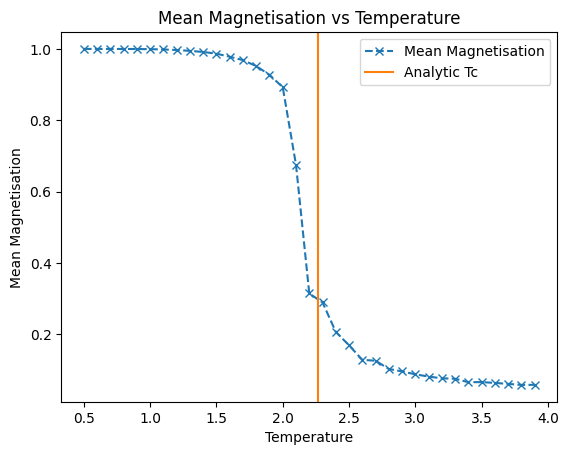

In [65]:
plt.plot(temperatures, mean_magnetisations, label='Mean Magnetisation', linestyle = '--', marker='x')
plt.axvline(CRITICAL_TEMP, color='tab:orange', label='Analytic Tc')
plt.xlabel('Temperature')
plt.ylabel('Mean Magnetisation')
plt.title('Mean Magnetisation vs Temperature')
plt.legend(loc='upper right')
plt.show()


Now lets do the plot for $n=10$, $n=50$, and $n=200$ sized lattices so we can see the finite lattice size effects

In [70]:
temperatures = np.arange(1, 4, 0.1)
mean_magnetisations = []
mean_magnetisations.append(get_phase_diagram(n = 10, temperatures = temperatures, steps = 2000))
mean_magnetisations.append(get_phase_diagram(n = 50, temperatures = temperatures, steps = 2000))
mean_magnetisations.append(get_phase_diagram(n = 200, temperatures = temperatures, steps = 2000))

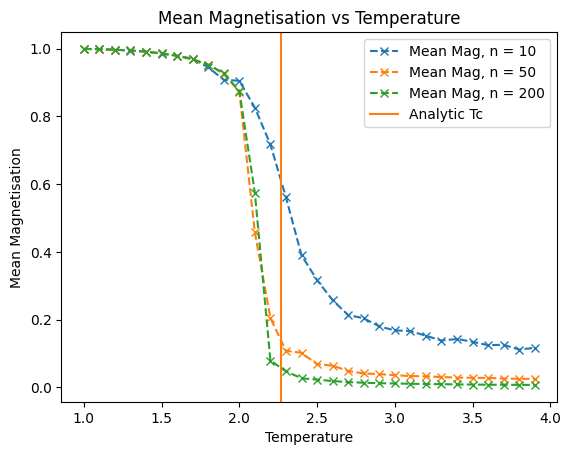

In [71]:
plt.plot(temperatures, mean_magnetisations[0], label='Mean Mag, n = 10', linestyle = '--', marker='x')
plt.plot(temperatures, mean_magnetisations[1], label='Mean Mag, n = 50', linestyle = '--', marker='x')
plt.plot(temperatures, mean_magnetisations[2], label='Mean Mag, n = 200', linestyle = '--', marker='x')
plt.axvline(CRITICAL_TEMP, color='tab:orange', label='Analytic Tc')
plt.xlabel('Temperature')
plt.ylabel('Mean Magnetisation')
plt.title('Mean Magnetisation vs Temperature')
plt.legend(loc='upper right')
plt.show()


We can see the $n=200$ sized lattice has the sharpest phase transition.